In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from src.utils import create_regression
from src.models import FEO, EnsembleModel
from scr.montecarlo import wang_landau

### Wang Landau estimate of entropy

To show that Monte Carlo method achieves entropy (state estimation) approximation equivalent to analytical solution

In [9]:
def random_walk(model, step_size=1e-3):
    noise = np.random.normal(size=model.shape) * step_size
    model += noise
    return model

def test_model(model, X_test, y_test):
    y_pred = X_test @ model
    return mean_squared_error(y_test, y_pred)

def stopping_criteria(h, thresh=0.8):
    m = np.mean(h)
    return np.all(h >= thresh * m)

def exponential_moving_average(past_ave, new_value, i, factor=10):
    return past_ave + (new_value - past_ave) / min(i, factor)

def stopping_criteria_saturation(h, delta_h_prev, thresh=100):
    delta_h = np.sum(h - np.min(h))
    return np.abs(delta_h - delta_h_prev) < thresh

def WangLandau(model, x, y, f=np.exp(1), init_g=None, step_size=2e-3, low=0, high=1, bins=100):
    bin_width = (high-low)/bins
    b = np.linspace(low, high, bins, endpoint=False)
    h = np.zeros_like(b)
    if init_g is not None:
        g = init_g
    else:
        g = np.zeros_like(b) + np.log(f)
    
    E1 = test_model(model, x, y)
    i = 1
    delta_h_prev = 0
    check_saturation_every = 1000
    while True:
        if i % check_saturation_every == 0:
            if stopping_criteria_saturation(h, delta_h_prev, int(check_saturation_every*0.05)):
                plt.figure(figsize=(2,1))
                plt.bar(b, h)
                plt.show()
                break
            else:
                delta_h_prev = exponential_moving_average(delta_h_prev, np.sum(h - np.min(h)), i//1000)

        E2 = high
        while E2 >= high or E2 < low:
            model_2 = random_walk(model.copy(), step_size=step_size)
            E2 = test_model(model_2, x, y)
        g1 = g[int((E1 - low)/bin_width)]
        g2 = g[int((E2 - low)/bin_width)]
        try:
            prob = min(np.exp(g1 - g2), 1)
        except RuntimeWarning:
            print(f'Overflow, g1: {g1}, g2: {g2}')
            return b, g, h

        if np.random.random() < prob:
            model = model_2
            g[int((E2 - low)/bin_width)] += np.log(f)
            h[int((E2 - low)/bin_width)] += 1
            #A[int((E1 - low)/bin_width)] += 1
            E1 = E2 
        else:
            g[int((E1 - low)/bin_width)] += np.log(f)
            h[int((E1 - low)/bin_width)] += 1
            #R[int((E1 - low)/bin_width)] += 1 

        if (i+1)%100000==0:
            print(np.mean(h)*0.8, np.min(h))

        i += 1
    return b, g, h

f:2.7183:   0%|          | 0/20 [00:00<?, ?it/s]

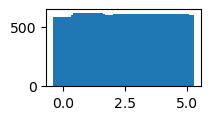

f:1.6487:   5%|▌         | 1/20 [00:06<02:02,  6.46s/it]

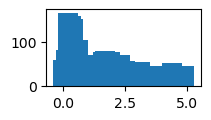

f:1.2840:  10%|█         | 2/20 [00:07<00:55,  3.10s/it]

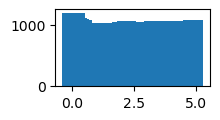

f:1.1331:  15%|█▌        | 3/20 [00:18<01:58,  6.99s/it]

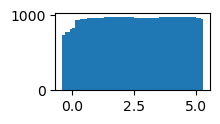

f:1.0645:  20%|██        | 4/20 [00:31<02:24,  9.05s/it]

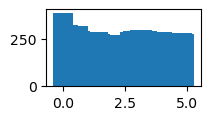

f:1.0317:  25%|██▌       | 5/20 [00:34<01:47,  7.19s/it]

1599.9840000000002 1850.0
3199.9840000000004 3800.0
4799.9839999999995 5887.0


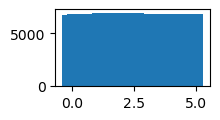

f:1.0157:  30%|███       | 6/20 [02:07<08:28, 36.31s/it]

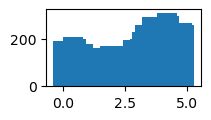

f:1.0078:  35%|███▌      | 7/20 [02:11<05:32, 25.58s/it]

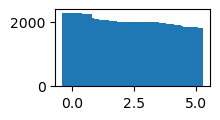

f:1.0039:  40%|████      | 8/20 [02:39<05:16, 26.40s/it]

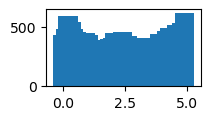

f:1.0020:  45%|████▌     | 9/20 [02:47<03:47, 20.69s/it]

1599.9840000000002 1504.0


In [10]:
low = int(test_model(theta_true, x, y)*10)/10
high = 5
bins = 50
step_size = 0.05
f = np.exp(1)
fs = []
while f > np.exp(1e-6):
    fs.append(f)
    f = np.sqrt(f)

g = None
bar = tqdm(fs)
for f in bar:
    bar.set_description(f'f:{f:.4f}')
    b, g, h = WangLandau(theta_true.copy(), x, y, f=f, init_g=g, step_size=step_size, low=low, high=high, bins=bins)

In [ ]:
if n == 2:
    xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    z = np.zeros_like(xx)
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i, j], yy[i, j]]).reshape(-1, 1)
            z[i, j] = test_model(theta, x, y)

if n == 2:
    plt.contourf(xx, yy, z, levels=30)
    plt.colorbar()

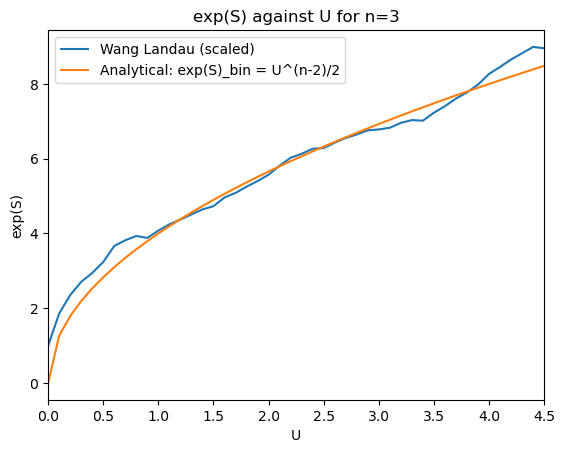

In [ ]:
b = np.append(np.linspace(low, high, bins, endpoint=False), high)
p = (n-1)/2
# integral = (1/(p+1))*b**(p+1)
# expS_bin = integral[1:] - integral[:-1]
# dexpS = (b**p)[1:] - (b**p)[:-1]
dAdU = (b[:-1])**((n-2)/2)

b = b[:-1]
plt.plot(b, np.exp(g-g[0]), label='Wang Landau (scaled)')
plt.plot(b, 4*dAdU, label=f'Analytical: exp(S)_bin = U^(n-2)/2')
plt.xlim(0, 4.5)
plt.ylabel('exp(S)')
plt.xlabel('U')
plt.title(f'exp(S) against U for n={n}')
plt.legend()

In [5]:
# define a some samples for training
# m: number of samples
# n: number of features

variables = 4
order = 1
include_bias = True
noise = 0
x = create_regression(1, variables, order, include_bias=include_bias)
n = x.shape[1]
ms = np.array([2, 5, 10, 50, 100]) * n
replicates = 50
u = np.arange(0, 5, 0.1)

results = pd.DataFrame({'m': [], 'u': [], 's': []})
for replicate in range(replicates):
    factors = []
    for m in ms:
        x = create_regression(m, variables, order, include_bias=include_bias)
        theta_true = np.random.random((n ,1))*2-1
        y = x @ theta_true + np.random.normal(0, noise, (m, 1))
        print(n)

        # check that sampled models give the correct training loss as required (u_star)
        temperature = 0.1
        fixed_u_star = False
        u_star_mul = np.sum(y**2) #n 
        L2_regularized = False

        feo = FEO(temperature, L2_regularized=L2_regularized)
        feo.fit(x, y, fixed_u_star=fixed_u_star, u_star_mul=u_star_mul)
        y_pred_train_feo = feo.predict(x, 50)
        print(np.mean(np.sum((y_pred_train_feo - y)**2, axis=0))/m)
        print(feo.u_star)

        #factors.append(feo.factor)
        s = feo.factor*u**((n-1)/2)
        results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)

5
0.07142765797975478
0.7142765797975499
5
0.002843544082952858
0.07108860207381391
5
0.00025294372002065393
0.012647186001038133
5
2.0743951065468163e-06
0.0005185987765208912
5
2.655536682141342e-07
0.00013277683424871287
5
0.08728627538098775
0.8728627538098858
5
0.0037054793116634253
0.09263698279158057
5
0.0003016416865781939
0.015082084328924281
5
2.2030826884246905e-06
0.0005507706722653824
5
2.6923162931779243e-07
0.00013461581438430122
5
0.053576659485863765
0.5357665948586301
5
0.0025404880841338674
0.06351220210335012
5
0.0003201258995225947
0.016006294976144406
5
2.0187851149558213e-06
0.0005046962787584852
5
2.608083472068939e-07
0.000130404173632408
5
0.054282533423700305
0.5428253342369965
5
0.0029309390068519275
0.0732734751712976
5
0.000326723678868815
0.016336183943451044
5
2.0774156113250656e-06
0.0005193539027722319
5
2.663576291297296e-07
0.00013317881475054247
5
0.037176765582399955
0.37176765582399807
5
0.002456746233125104
0.06141865582813234
5
0.000280625003028

C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log


0.08698528897416491
0.8698528897416481
5
0.002214328553159389
0.05535821382898487
5
0.0002561839004854961
0.012809195024239682
5
2.0117249929398785e-06
0.0005029312483137453
5
2.5342265570317213e-07
0.00012671132783682802
5
0.10140508105817958
1.0140508105818005
5
0.002198034908796417
0.054950872719909116
5
0.00029146229224067977
0.01457311461202071
5
2.1899648158977357e-06
0.000547491204145282
5
2.489331113792862e-07
0.0001244665557142099
5
0.06151734167956176
0.6151734167956158
5
0.0020439104054680956
0.051097760136704445
5
0.00027831324872259664
0.013915662436129739
5
2.1609391494617744e-06
0.0005402347873152125
5
2.4791745067887285e-07
0.00012395872544282636
5
0.09552357472691483
0.9552357472691455
5
0.0026986780874673853
0.06746695218668046
5
0.00026993390486424525
0.013496695243259239
5
2.0121529431661778e-06
0.0005030382358529634
5
2.602559674187342e-07
0.0001301279837538486
5
0.11611154143672735
1.1611154143672742
5
0.00219615447037128
0.0549038617592759
5
0.0002425616721069431

C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log
  results = pd.concat((results, pd.DataFrame({'m': str(m), 'u': u, 's': np.log(s)})), ignore_index=True)
C:\Users\zhout\AppData\Local\Temp\ipykernel_9192\408643456.py:38: RuntimeWarning: divide by zero encountered in log


In [6]:
results['f'] = results['u'] - results['s']

Text(0.5, 0, 'U')

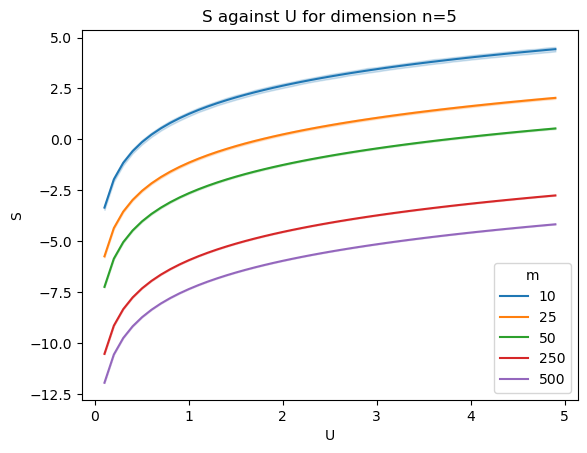

In [8]:
sns.lineplot(data=results, x='u', y='s', hue='m')
plt.title(f"S against U for dimension n={n}")
plt.ylabel('S')
plt.xlabel('U')

Text(0.5, 0, 'U')

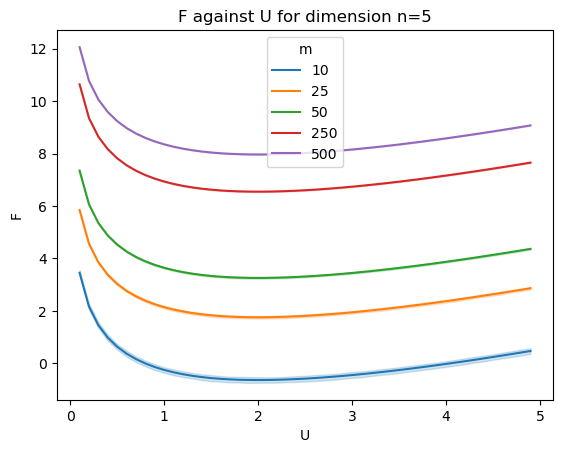

In [7]:
sns.lineplot(data=results, x='u', y='f', hue='m')
plt.title(f"F against U for dimension n={n}")
plt.ylabel('F')
plt.xlabel('U')